https://archive.ics.uci.edu/dataset/462/drug+review+dataset+drugs+com

# Flatiron Phase 5 Project

## Aaron Galbraith

https://www.linkedin.com/in/aarongalbraith \
https://github.com/aarongalbraith

### Submitted: November 21, 2023

## working contents

- **[functions](#functions)<br>**
- **[rough overview](#rough-overview)<br>**
- **[missing values](#missing-values)<br>**
- **[duplicates](#duplicates)<br>**
- **[brand / generic pairs](#brand-/-generic-pairs)<br>**
- **[further exploration of duplicates (skip for now)](#further-exploration-of-duplicates-(skip-for-now))<br>**
- **[contractions](#contractions)<br>**
- **[dates](#dates)<br>**
- **[ratings](#ratings)<br>**
- **[save and reload preprocessed set](#save-and-reload-preprocessed-set)<br>**
- **[feature engineering ideas](#feature-engineering-ideas)<br>**
- **[end](#end)<br>**


## Contents

- **[Business Understanding](#Business-Understanding)<br>**
- **[Data Understanding](#Data-Understanding)**<br>
- **[Data Preparation](#Data-Preparation)**<br>
- **[Exploration](#Exploration)**<br>
- **[Modeling](#Modeling)**<br>
- **[Evaluation](#Evaluation)**<br>
- **[Recommendations](#Recommendations)<br>**
- **[Further Inquiry](#Further-Inquiry)**<br>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud

import html
import contractions

import re

from IPython.display import display

import seaborn as sns

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from pathlib import Path

SEED = 1979

do_grids = True

In [ ]:
d1 = pd.read_csv('../data/drugsComTrain_raw.tsv', delimiter='\t', encoding='latin-1')
d2 = pd.read_csv('../data/drugsComTest_raw.tsv', delimiter='\t', encoding='latin-1')
df = pd.concat([d1,d2]).reset_index().drop(columns=['Unnamed: 0', 'index'])

# functions

In [2]:
def show_review(index):
    print(df.review.loc[index])
    display(df[df.review == df.loc[index].review][['drugName', 'condition', 'rating', 'date', 'usefulCount']])

In [3]:
# a function that takes a list of tweets and 1) tokenizes them, 2) lemmatizes them, and 3) removes stopwords
def make_tokens(reviews, stop_list):
    # make list of tokens
    tokens = nltk.word_tokenize(','.join(reviews))
    tokens_lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    # stop tokens
    tokens_stopped = [word for word in tokens_lemmatized if \
                      word not in stop_list]
    return tokens_stopped

In [4]:
# a function that generates a word cloud of a given list of words
def make_wordcloud(wordlist, colormap='Greens', title=None):
    # instantiate wordcloud
    wordcloud = WordCloud(
        width=600,
        height=400,
        colormap=colormap,
        collocations = True
    )
    return wordcloud.generate(','.join(wordlist))

In [5]:
# a function that plots the word cloud
def plot_wordcloud(wordcloud):
    # plot wordcloud
    plt.figure(figsize = (12, 15)) 
    plt.imshow(wordcloud) 
    plt.axis('off');

In [6]:
def plot_useful(feature, low=0.15, high=0.85):
    X = range(int(df[feature].quantile(low)), int(df[feature].quantile(high)))
    Y = []
    for x in X:
        Y.append(df[df[feature] == x].usefulCount.mean())
    fig, ax = plt.subplots()
    ax.plot(X,Y);

# rough overview

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
df.info()

There are some missing condition labels.

In [ ]:
df.drugName.value_counts()

In [ ]:
df.drugName.value_counts().quantile(.90)

There are 3,671 unique drug names, and 10% of the drug names have more than 120 reviews.

In [ ]:
df.condition.value_counts()

In [ ]:
df.condition.value_counts().quantile(.90)

There are 916 unique conditionis, and 10% of the conditions have more than 332 reviews.

In [ ]:
df.rating.value_counts()

In [ ]:
df.rating.hist(bins=10);

Most of the conditions lie at the extremes, and more of them appear to be at the positive extreme.

In [ ]:
df.groupby('drugName').condition.nunique().value_counts()

This means that, for example, 1869 drugs treat 1 condition only, etc.

In [ ]:
df.groupby('condition').drugName.nunique().value_counts()

This means that 188 conditions are treatable by two drugs, etc.

In [ ]:
pd.set_option("display.max_rows", None)
print(df.drugName.value_counts())
pd.set_option("display.max_rows", 10)

A casual overview of the drug names indicates that they all seem valid. Some seem to specify drug combinations and/or dosage amounts.

In [ ]:
pd.set_option("display.max_rows", None)
print(df.condition.value_counts())
pd.set_option("display.max_rows", 10)

Oddly, the condition labels often (always?) omit initial 'F' and terminal 'r'. We can isolate instances of the former by searching for conditions that start with a lower case letter.

We will eventually trim our records to a number of conditions that Planned Parenthood specializes in treating, but we will need all the records to help us determine missing condition labels. After we have restored (or discarded) all missing condition labels, we can drop the conditions outside the scope of this review.

## dates

(Do this date analysis *after* we have trimmed to just the records we'll use?)

There's probably a datetime method for this, but the following will produce month // day // year, and then we can figure out the earliest and latest dates.

In [ ]:
df['month'] = df.date.apply(lambda x: re.split(r'\W+', x)[0])
df['day'] = df.date.apply(lambda x: int(re.split(r'\W+', x)[1]))
df['year'] = df.date.apply(lambda x: int(re.split(r'\W+', x)[2]))

In [ ]:
df.year.min()

In [ ]:
df[df.year == 2008].month.value_counts()

In [ ]:
df[(df.year == 2008) &
   (df.month == 'February')
  ].day.min()

In [ ]:
df.year.max()

In [ ]:
df[df.year == 2017].month.value_counts()

In [ ]:
df[(df.year == 2017) &
   (df.month == 'December')
  ].day.max()

The reviews span from February 24, 2008 to December 12, 2017.

In [ ]:
df.year.hist();

## review text

In [ ]:
for i in range(10):
    print(df.review[i], '\n-----')

# language cleaning

Before we go any further, we would like to clean up some of the review text. In particular, there are many escaped characters, especially apostrophes.

Here is an example of a contraction.

In [ ]:
df.review[3][56:69]

Here is how the html function fixes it.

In [ ]:
html.unescape(df.loc[3][2])[56:64]

Here is how the contractions function fixes (the html function's fix of) it.

In [ ]:
contractions.fix(html.unescape(df.loc[3][2]))[56:65]

Here is an instance of "ain't" with the same functions applied.

In [ ]:
df.review.loc[507][75:99]

In [ ]:
html.unescape(df.review.loc[507])[75:94]

In [ ]:
contractions.fix(html.unescape(df.review.loc[507]))[75:96]

In [ ]:
len(df[df.review.str.contains('ain&#039;t')])

There are 53 instances of "ain't".

I'm currently having difficulty downloading the package that appropriately fixes "ain't" into "is not" or "are not" etc. This shouldn't matter after I remove stop words. I think it will be helpful to exclude negatives like "no" and "not" from the stop words. It could certainly be of help to look for bigrams like "not good".

In [ ]:
df.review = df.review.apply(lambda x: contractions.fix(html.unescape(x)))

# missing values

In [ ]:
len(df[df.condition.isna()])

In [ ]:
df.condition.fillna('missing', inplace=True)

In [ ]:
len(df[df.condition == 'missing'])

We noticed another condition label that was meant to indicate missing and should be accordingly changed.

In [ ]:
df.condition = df.condition.apply(lambda x: 'missing' if 'Not Listed' in x else x)

In [ ]:
len(df[df.condition == 'missing'])

We've identified some actual missing condition labels, but we noticed there are more condition labels that seem suspicious, particularly ones that start with something other than an upper case character. Let's look at all such condition labels.

In [ ]:
set(df[(~df.condition.str[0].isin(list(string.ascii_uppercase))) &
   (df.condition != 'missing')
  ].condition)

These fall into three categories. Ones that include "users found this comment helpful" should be regarded as erroneous and therefore missing.

In [ ]:
df.condition = df.condition.apply(lambda x: 'missing' if 'users found' in x else x)

In [ ]:
len(df[df.condition == 'missing'])

Ones that show a clipped copy of the drug name label and end with a parenthesis should also be regarded as missing.

In [ ]:
df.condition = df.condition.apply(lambda x: 'missing' \
                                  if x[0] not in list(string.ascii_uppercase) and \
                                  x[-1] in ['(', ')'] \
                                  else x)

In [ ]:
len(df[df.condition == 'missing'])

# restoring erroneous condition labels

(skip this step because we're just focusing on birth control?)

Most of the ones that show a clipped version of the condition label can possibly be restored.

In [ ]:
def condition_restore(condition):
    if condition.split()[-1] in ['Disorde', 'eve', 'Shoulde', 'Cance']:
        condition = condition+'r'
    if condition.split()[0] in ['acial', 'ibrocystic', 'ungal', 'amilial', 'ailure', 'ever', \
                                'emale', 'unctional', 'actor', 'ibromyalgia', 'atigue']:
        condition = 'F'+condition
    if condition.split()[0] in ['llicular', 'llicle', 'lic', 'cal']:
        condition = 'Fo'+condition
    if condition.split()[0] in ['mance']:
        condition = 'Perfor'+condition
    if condition.split()[0] in ['zen']:
        condition = 'Fro'+condition
    if condition.split()[0] in ['mis']:
        condition = 'Dermatitis Herpetifor'+condition
    return condition

df.condition = df.condition.apply(lambda x: condition_restore(x))

Let's look at what we have left.

In [ ]:
set(df[(~df.condition.str[0].isin(list(string.ascii_uppercase))) &
   (df.condition != 'missing')
  ].condition)

"von Willebrand's Disease" appears to be a naturally uncapitalized condition. The others have been impossible to restore and will also be regarded as missing.

In [ ]:
df.condition = df.condition.apply(lambda x: 'missing' \
                                  if x[0] not in list(string.ascii_uppercase) and \
                                  x.split()[0] != 'von' \
                                  else x)

In [ ]:
len(df[df.condition == 'missing'])

We will be able to restore more of these missing condition labels after we do some work with duplicates.

# duplicates

In [ ]:
df.duplicated().value_counts()

In [ ]:
df[df.duplicated()]

In [ ]:
show_review(178703)

This is curious. The same review is recorded four times. There are two identical pairs, where the difference between the pairs is the drug name. We can drop one from each pair, but the pairs themselves will need to be revisited.

In [ ]:
df.drop_duplicates(inplace=True)

# brand / generic pairs

The main type of duplicate we should look out for is records with duplicate reviews, as those likely indicate some kind of actual erroneous duplication. Let's see how many of those there are.

In [ ]:
df.duplicated(subset=['review']).value_counts()

That's a lot!

Let's explore some facets of these duplicates.

In [ ]:
len(df[df.duplicated(subset=df.columns.difference(['drugName']))])

The vast majority of duplicate reviews are accounted for by different drug names. Let's explore some examples.

In [ ]:
df[df.duplicated(subset=df.columns.difference(['drugName']))].head()

In [ ]:
show_review(524)

In [ ]:
show_review(574)

In [ ]:
show_review(726)

In [ ]:
show_review(1070)

In [ ]:
show_review(1375)

These five examples make clear that the vast majority of duplicates are due to double-entry; (nearly) every review is entered once with its generic name and once with its brand name.

We can use this phenomenon to restore some of the missing condition labels. If a missing condition label is part of such a unique pair, then we can confidently assign it the condition of its pair-mate.

Let's broaden our search to records that duplicate every feature other than drug name and condition.

In [ ]:
len(df[df.duplicated(subset=df.columns.difference(['drugName', 'condition']))])

This is how many records are duplicates of other records in all values EXCEPT (POSSIBLY) drug name and condition. If a record is duplicated in this manner, the second (and third, fourth, etc.) instance will be captured in this bucket of dupes.

If we check only this bucket for dupes, we can see whether there are any triplets, etc.

In [ ]:
df_dupes = df[df.duplicated(subset=df.columns.difference(['drugName', 'condition']))]

In [ ]:
len(df_dupes[df_dupes.duplicated(subset=df_dupes.columns.difference(['drugName', 'condition']))])

There is only one.

In [ ]:
df_dupes[df_dupes.duplicated(subset=df_dupes.columns.difference(['drugName', 'condition']))]

In [ ]:
show_review(140144)

There are 6 records with the same review, date, rating, and condition. (The reviews on October 5, 2012, appear to be just a coincidence of the same review wording.) Because they're on the *same day*, it seems likely that these reviews were possibly entered repeatedly by the same person. The two with a useful count of 10 are likely a brand/generic pair.

As for the other 4, it's not clear what is going on. We will (would) later discover that there is also some discrepancy as to which of these is a brand or generic name. Since the review text isn't very descriptive, and the useful count is so low, (and it doesn't pertain to the main conditions treated by Planned Parenthood), let's just drop all 4.

In [ ]:
df.drop([60998, 119972, 133212, 140144], inplace=True)

Now we should be able to create a list of pairs of indices of records that match in all features except possibly drug name and condition. To make this run faster, we'll first create a way to sort them by date.

In [ ]:
%%time
# ⏰ record the time for this cell -- usually 11-12 s

# create stripped down dataframe that does not have drug names or conditions
# we don't need these features for this operation because we're checking for matches on all other features
df_pairs = df.drop(columns=['drugName', 'condition']).copy()

# create a list of indices of records that duplicate everything other than drug name and condition
df_dupes = df_pairs[df_pairs.duplicated()].index.tolist().copy()

# create and populate a dictionary whose keys are dates and whose values are indices
dates_dict = {}
# populate dictionary with keys that are dates belonging to the duplicates
for date_ in list(set(df[df.index.isin(df_dupes)].date.tolist())):
    dates_dict[date_] = []
# populate dictionary with values that are indices that are NOT from the duplicate list but DO share that date
for i in df[~df.index.isin(df_dupes)].index:
    dates_dict[df.loc[i].date].append(i)

Now we can use this dates dictionary to sort and identify the pairs.

In [ ]:
%%time
# ⏰ record the time for this cell -- usually 2–4 mins

# create a list of record pairs where each entry is a list of two indices
pairs = []

# iterate over the indices from the dupes list
for i in df_dupes:
    # set the date to the date from index i
    date_i = df.loc[i].date
    # iterate over OTHER indices who share that date
    for j in dates_dict[date_i]:
        # check for a match
        if df_pairs.loc[i].equals(df_pairs.loc[j]) and df.drugName.loc[i] != df.drugName.loc[j]:
            # remove this index from the dates dictionary so we have fewer to search through in later iterations
            dates_dict[date_i].remove(j)
            # add this pair to the pairs list
            pairs.append([i,j])
            break

Let's take a look at several of the pairs we've collected.

In [ ]:
pairs[:10]

Here we'll create a dictionary that matches the index of one pair member to the other member of the pair.

In [ ]:
pairs_dict = {}

for pair in pairs:
    for i in range(2):
        pairs_dict[pair[i]] = pair[1-i]

# restore missing condition labels

We will restore missing condition labels in two ways, in order of certainty:

1. For missing values that possess a pair match, we will assign it the condition of its match.
2. For the remaining missing values, we will assign it the condition that is most commonly associated with its drug name.

In [ ]:
len(df[df.condition == 'missing'])

In [ ]:
%%time
# ⏰ record the time for this cell -- usually 10-15 seconds

# iterate over each record pair
for pair in pairs:
    # iterate over each member of the pair
    for i in range(2):
        # identify a pair member whose condition is missing
        if df.loc[pair[i]].condition == 'missing':
            # assign to the pair member the condition of its pair-mate
            df.at[pair[i], 'condition'] = df.loc[pairs_dict[pair[i]]].condition

In [ ]:
len(df[df.condition == 'missing'])

Because it will be useful later, we'll make a feature that names the indicated drug and, if applicable, the paired drug.

This is not a *final* replacement for the drug name feature, but it will allow us to better recognize the relationship between the generic and brand drug names.

In [ ]:
%%time
# ⏰ record the time for this cell -- usually 15-30 seconds

df['ind'] = df.index

def drugList_fix(index, drugName_):
    drugList = [drugName_]
    if index in pairs_dict:
        drugList.append(df.loc[pairs_dict[index]].drugName)
        # alphabetize each drug pair so that we will not mistakenly duplicate e.g. [A,B] & [B,A]
        drugList.sort()
    return drugList

df['drugList'] = df.apply(lambda x: drugList_fix(x.ind, x.drugName), axis=1)

df.drop(columns='ind', inplace=True)

Now we can create a feature that tells us if a record is associated with a paired drug name or not.

In [ ]:
df['isPaired'] = df.drugList.apply(lambda x: True if len(x) > 1 else False)

In [ ]:
len(df[df.isPaired])

In [ ]:
len(df[~df.isPaired])

Because lists confuse certain operations

In [ ]:
df['drugSetString'] = df.drugList.apply(lambda x: x[0] + ' ' + x[1] if len(x) == 2 else x[0])

In [ ]:
len(df[df.duplicated(subset=df.columns.difference(['drugName', 'drugSet', 'drugList']))])

With this new feature in place, we can drop one record from each of the brand/generic pairs. The drug name feature will retain only one member of the pair -- unpredictably either the brand or the generic -- which will make this feature more or less useless for the moment.

Before we drop these records, we'll create a bookmark copy of the dataframe.

In [ ]:
# DO NOT re-run this cell out of sequence
# to use the dataframe as it was at this stage, un-comment, run, and re-comment the cell that follows after it.
df_bookmark_1 = df.copy()

In [ ]:
# df = df_bookmark_1.copy()

In [ ]:
df.drop_duplicates(subset=df.columns.difference(['drugName', 'drugSet', 'drugList']), inplace=True)

For every remaining record with a missing condition, we will assign it the condition that is most common for the drug indicated by that record. (This will not be biased by duplicates from brand/generic pairs, because we have dropped those duplicates.)

This will be the last use we have for conditions *not* treated by Planned Parenthood.

In [ ]:
drugs_w_missing_condition = list(set(df[df.condition == 'missing'].drugSetString))

In [ ]:
len(drugs_w_missing_condition)

In [ ]:
df.drugSetString.nunique()

This applies to some 20% of the drugs. We'll create a dictionary that reports the most common condition for these drugs.

In [ ]:
%%time
# record the time for this cell -- 10-20 seconds

most_common_condition = {}

for drug in drugs_w_missing_condition:
    condition = df[df.drugSetString == drug].condition.value_counts().idxmax()
    if condition == 'missing' and len(set(df[df.drugSetString == drug].condition)) > 1:
        condition = df[(df.drugSetString == drug) &
                       (df.condition != 'missing')
                      ].condition.value_counts().idxmax()
    proportion = round(df[df.drugSetString == drug].condition.value_counts(normalize=True)[0],2)
    most_common_condition[drug] = [condition, proportion]

In [ ]:
most_common_condition['Sildenafil Viagra']

For example, if a review with an unlisted condition is about Viagra, we will assume the condition is Erectile 
Dysfunction.

In [ ]:
len(df[df.condition == 'missing'])

In [ ]:
df['condition'] = df.apply(lambda x: most_common_condition[x.drugSetString][0] \
                           if x.condition == 'missing' \
                           else x.condition, axis = 1)

In [ ]:
len(df[df.condition == 'missing'])

This is how many records there are that still have no condition label. This means the drugs indicated in these records are *only* indicated in references without an indicated condition. As such, there's not really anything we can do with these records, and we may as well drop them.

In [ ]:
df.drop(df[df.condition == 'missing'].index, inplace=True)

In [ ]:
len(df[df.condition == 'missing'])

# trim by conditions

At this point, we still have more cleaning to do, but we have identified all the conditions that we can, and we won't have any further need for records with certain condition values, so we'll drop them.

In [ ]:
# DO NOT re-run this cell out of sequence
# to use the dataframe as it was at this stage, un-comment, run, and re-comment the cell that follows after it.
df_bookmark_2 = df.copy()

In [ ]:
# df = df_bookmark_2.copy()

Let's take another look at the complete list of conditions and choose which ones to keep.

In [ ]:
df.condition.nunique()

Since there are so many conditions to consider, let's limit this to just conditions with at least 25 reviews.

In [ ]:
pd.set_option("display.max_rows", None)
display(df['condition'].value_counts().loc[lambda x: x >= 25])
pd.set_option("display.max_rows", 10)

In [ ]:
pp_conditions = [
    'Birth Control', 'Emergency Contraception', 'Abnormal Uterine Bleeding', \
    'Menstrual Disorders', 'Female Infertility', 'Uterine Fibroids'
]

In [ ]:
df.drop(df[~df.condition.isin(pp_conditions)].index, inplace=True)

In [ ]:
df.condition.value_counts()

In [ ]:
df[df.year == df.year.min()].month.value_counts()

In [ ]:
df[(df.year == df.year.min()) &
   (df.month == 'February')
  ].day.min()

In [ ]:
df[df.year == df.year.max()].month.value_counts()

In [ ]:
df[(df.year == df.year.max()) &
   (df.month == 'December')
  ].day.max()

The reviews span from February 24, 2008 to November 30, 2017.

# exploring generic and brand names

Now that we have a smaller number of records to deal with, we can sort out generic and brand names.

First we'll create a list of all values from the drug name feature. (Some of these have been dropped from the drug name feature itself when we dropped one record from each brand/generic pair, but all of them were included in the drug list feature.)

We'll create two lists: paired drugs (which we will attempt to sort into brand and generic) and single drugs (each of which we will then try to identify as either brand or generic).

In [ ]:
len(df)

In [ ]:
all_drug_lists = df.drugList.tolist()
all_drug_lists.sort()

In [ ]:
len(all_drug_lists)

In [ ]:
all_drug_names = set()

for list_ in all_drug_lists:
    all_drug_names.add(list_[0])
    if len(list_) > 1:
        all_drug_names.add(list_[1])

all_drug_names = list(all_drug_names)

all_drug_names.sort()

In [ ]:
len(all_drug_names)

In [ ]:
# this will create a full list with duplicates
# we need to do this intermediate before moving to the following step to remove duplicates
paired_drug_lists = df[df.isPaired].drugList.tolist()
paired_drug_lists.sort()

In [ ]:
len(paired_drug_lists)

In [ ]:
paired_drug_names = set()

for pair in paired_drug_lists:
    paired_drug_names.add(pair[0])
    paired_drug_names.add(pair[1])

paired_drug_names = list(paired_drug_names)

paired_drug_names.sort()

In [ ]:
unpaired_drug_names = [drug for drug in all_drug_names if drug not in paired_drug_names]

unpaired_drug_names.sort()

In [ ]:
len(paired_drug_names)

In [ ]:
len(unpaired_drug_names)

Together, these two lists of names constitute all the drug names left to sort into brand and generic categories.

In order to sort the list of paired drugs into brand and generic, we'll establish a dictionary whose keys are all the drug names that appear in a generic/brand pair.

In [ ]:
drug_dict = {}

for drug in paired_drug_names:
    drug_dict[drug] = set()

We'll assign values to those keys according to the pairings. For example, if drug name A is in a generic/brand pair with drug name B, then they will appear on each other's list of values in this dictionary.

In [ ]:
for pair in paired_drug_lists:
    drug_dict[pair[0]].add(pair[1])
    drug_dict[pair[1]].add(pair[0])

Let's find out how many of these drug names are associated with exactly one other drug name.

In [ ]:
len({drug for drug in drug_dict if len(drug_dict[drug]) == 1})

That should mean that exactly the remainder are associated with multiple drug names. It would make sense that drug names that belong to multiple generic/brand pairs are themselves the generic name. On that assumption, we'll create a list of generic drug names.

In [ ]:
generics = [drug for drug in drug_dict if len(drug_dict[drug]) > 1]

generics.sort()

In [ ]:
len(generics)

Now we'll check to make sure that the drug names we've just designated as "generic" do NOT belong to a generic/brand pair with *another* "generic".

In [ ]:
count = 0

for drug in generics:
    for match in drug_dict[drug]:
        if match in generics:
            count += 1

print(count)

Great.

Then we can begin designating drug names as "brands" if they are in a generic/brand pair with a generic.

In [ ]:
brands = set()

for generic in generics:
    for match in drug_dict[generic]:
        brands.add(match)

brands = list(brands)

brands.sort()

In [ ]:
len(brands)

Now let's see what drugs remain and how many records they are associated with.

In [ ]:
uncategorized = list(set(drug for drug in paired_drug_names if drug not in generics and drug not in brands))

uncategorized.sort()

To be clear, these are drug names with the following properties:

- the drug name belongs to an exclusive brand/generic pair
- we have not yet identified which members of the pair are brand and generic

In [ ]:
len(uncategorized)

We should be able to list all of these drug names in their pairs.

In [ ]:
repeated = set()
for drug in uncategorized:
    if drug not in repeated:
        print(drug, '||', list(drug_dict[drug])[0])
        repeated.add(drug)
        repeated.add(list(drug_dict[drug])[0])

With so few pairs, we can Google the names to determine which names of a pair are generic and brand names.

In [ ]:
new_brands = [
    'Clomid', 'Premarin', 'ParaGard', 'Natazia', 'NuvaRing', 'Femara', \
    'Glucophage', 'Lysteda', 'Megace', 'Necon 1 / 50', 'ella'
]

brands.extend(new_brands)

len(brands)

In [ ]:
for drug in new_brands:
    generics.append(list(drug_dict[drug])[0])

len(generics)

At this point, we have sorted all the paired brand and generic drug names. What remains is to identify whether each of the single drug names is a generic or brand name.

Let's look at them.

In [ ]:
unpaired_drug_names

Simple Google search confirms these are both generic names, so we'll add them as such.

In [ ]:
generics.extend(unpaired_drug_names)

generics.sort()

Now we create a more universal drug naming system whereby every record is identified with its generic name.

In [ ]:
def generic_fix(drugList):
    if len(drugList) == 1 or drugList[0] in generics:
        return drugList[0]
    else:
        return drugList[1]

df['genericName'] = df.drugList.apply(lambda x: generic_fix(x))

In [ ]:
def full_brand_fix(drugList):
    if len(drugList) == 1:
        return None
    elif drugList[0] in brands:
        return drugList[0]
    else:
        return drugList[1]

df['fullBrandName'] = df.drugList.apply(lambda x: full_brand_fix(x))

In [ ]:
brand_dict = {}

for fullName in brands:
    name = fullName
    tail = name.split()[-1]
    while tail.isnumeric() or tail in ['Fe', 'Lo', 'One-Step', '/', '1.5', 'Contraceptive']:
        name = name[:len(name)-len(tail)-1]
        tail = name.split()[-1]
    head = name.split()[0]
    while head in ['Lo', '/']:
        name = name[len(head)+1:]
        head = name.split()[0]
    brand_dict[fullName] = name

df['shortBrandName'] = df.fullBrandName.apply(lambda x: None if x == None else brand_dict[x])

# further exploration of duplicates

Now we'll turn to more possible duplicate instances. We suspect the same user has copy-pasted an identical review multiple times when that verbatim review appears for the same condition and (generic) drug name with the same rating. Let's look at all such instances.

In [ ]:
len(df[df.duplicated(subset=['genericName', 'condition', 'review', 'rating'])])

In [ ]:
df[df.duplicated(subset=['genericName', 'condition', 'review', 'rating'])] \
[['genericName', 'condition', 'review', 'rating', 'date']]

The review texts all appear to be unique. As long as the review and its duplicate appear close in time to one another (within days), then these should be collapsed into a single review with the respective useful counts added together.

First we'll check on the dates. The following cell will show the respective dates of when these duplicated reviews appeared.

In [ ]:
for ind in df[df.duplicated(subset=['genericName', 'condition', 'review', 'rating'])].index:
    two_indices = list(df[df.review == df.loc[ind].review].index)
    print(df.loc[two_indices[0]].date, '... and ...', df.loc[two_indices[1]].date)

They're all identical dates except one that is a day apart.

We'll collapse these into single records and add the useful counts.

In [ ]:
for ind in df[df.duplicated(subset=['genericName', 'condition', 'review', 'rating'])].index:
    two_indices = list(df[df.review == df.loc[ind].review].index)
    x, y = two_indices[0], two_indices[1]
    count = int(df.loc[x].usefulCount + df.loc[y].usefulCount)
    df.at[x, 'usefulCount'] = count
    df.drop([y], inplace=True)

In [ ]:
# DO NOT re-run this cell out of sequence
# to use the dataframe as it was at this stage, un-comment, run, and re-comment the cell that follows after it.
df_bookmark_3 = df.copy()

In [ ]:
# df = df_bookmark_3.copy()

# exploring final data set

In [ ]:
df.rating.hist(bins=10);

# exploration of rating and useful count

In [ ]:
X = range(1,11)
Y = []
for x in X:
    Y.append(df[df.rating == x].usefulCount.mean())
fig, ax = plt.subplots()
ax.bar(X,Y);

This shows the average useful count by rating from 1 to 10. It seems that ratings of 8 and above are considered more useful than the others.

In [ ]:
threshold = 20

uv = list(df.usefulCount.values)
uv.sort(reverse=True)
n = 0
while sum(uv[:n]) < threshold / 100 * df.usefulCount.sum():
    n += 1
print(str(int(n * 100 / len(df)))+'%','of the reviews received', str(threshold)+'%', 'of all the upvotes.')
print('This includes reviews with', uv[n], 'or more upvotes')

In [ ]:
df[df.usefulCount >= 46].rating.value_counts(normalize=True)

In [ ]:
threshold = 40

uv = list(df.usefulCount.values)
uv.sort(reverse=True)
n = 0
while sum(uv[:n]) < threshold / 100 * df.usefulCount.sum():
    n += 1
print(str(int(n * 100 / len(df)))+'%','of the reviews received', str(threshold)+'%', 'of all the upvotes.')
print('This includes reviews with', uv[n], 'or more upvotes')

In [ ]:
df[df.usefulCount >= 21].rating.value_counts(normalize=True)

In [ ]:
threshold = 60

uv = list(df.usefulCount.values)
uv.sort(reverse=True)
n = 0
while sum(uv[:n]) < threshold / 100 * df.usefulCount.sum():
    n += 1
print(str(int(n * 100 / len(df)))+'%','of the reviews received', str(threshold)+'%', 'of all the upvotes.')
print('This includes reviews with', uv[n], 'or more upvotes')

In [ ]:
df[df.usefulCount >= 12].rating.value_counts(normalize=True)

In [ ]:
threshold = 80

uv = list(df.usefulCount.values)
uv.sort(reverse=True)
n = 0
while sum(uv[:n]) < threshold / 100 * df.usefulCount.sum():
    n += 1
print(str(int(n * 100 / len(df)))+'%','of the reviews received', str(threshold)+'%', 'of all the upvotes.')
print('This includes reviews with', uv[n], 'or more upvotes')

In [ ]:
df[df.usefulCount >= 7].rating.value_counts(normalize=True)

In [ ]:
threshold = 95

uv = list(df.usefulCount.values)
uv.sort(reverse=True)
n = 0
while sum(uv[:n]) < threshold / 100 * df.usefulCount.sum():
    n += 1
print(str(int(n * 100 / len(df)))+'%','of the reviews received', str(threshold)+'%', 'of all the upvotes.')
print('This includes reviews with', uv[n], 'or more upvotes')

In [ ]:
df[df.usefulCount >= 3].rating.value_counts(normalize=True)

In [ ]:
X = range(0,len(df),100)
Y = []
for x in X:
    Y.append(sum(uv[:x]))
fig, ax = plt.subplots()
ax.plot(X,Y);

This shows the cumulative sum of upvotes. For example, if we go 5% of the reviews in from the left on the x-axis, we would reach up to 33% of the total upvotes on the y-axis.

# feature engineering ideas

- word count
- character count
- words in all caps
- average word length
- whether words are in English (spelled correctly)
- whether it includes characters such as exclamation points, question marks, (especially repeatedly), and emoticons
- whether it mentions the brand or generic name in the review
- whether it uses slang versus technical language
- whether it mentions touchy subjects such as abortion
- ngrams

In [ ]:
engineered_features = []

In [ ]:
df['raw_tokens'] = df.review.apply(lambda x: nltk.word_tokenize(x))

In [ ]:
df['review_lower'] = df['review'].str.lower()

# all caps words

In [ ]:
def all_caps_fix(tokens_list):
    count = 0
    for token in tokens_list:
        if len(token) > 2 and token.isupper():
            count += 1
    return count

df['all_caps'] = df.raw_tokens.apply(lambda x: all_caps_fix(x))

In [ ]:
df.all_caps.value_counts()[:10]

In [ ]:
plot_useful('all_caps', high=0.99)

In [ ]:
engineered_features.append('all_caps')

# no caps usage

In [ ]:
df['no_caps'] = df.apply(lambda x: 1 if x.review == x.review_lower else 0, axis=1)

In [ ]:
df.no_caps.value_counts()

In [ ]:
df[df.no_caps == 1].usefulCount.mean()

In [ ]:
df[df.no_caps == 0].usefulCount.mean()

In [ ]:
engineered_features.append('no_caps')

# exclaim count

In [ ]:
df['exclaim_count'] = df.raw_tokens.apply(lambda x: x.count('!'))

In [ ]:
df.exclaim_count.value_counts()[:10]

In [ ]:
plot_useful('exclaim_count', high=0.995)

In [ ]:
engineered_features.append('exclaim_count')

# question count

In [ ]:
df['question_count'] = df.raw_tokens.apply(lambda x: x.count('?'))

In [ ]:
df.question_count.value_counts()

In [ ]:
plot_useful('question_count', low=0.01, high=0.999)

In [ ]:
engineered_features.append('question_count')

# word count

In [ ]:
df['word_count'] = df.raw_tokens.apply(lambda x: len(x))

In [ ]:
plot_useful('word_count')

In [ ]:
engineered_features.append('word_count')

# character count

In [ ]:
df['character_count'] = df.review.apply(lambda x: len(x))

In [ ]:
plot_useful('character_count')

In [ ]:
engineered_features.append('character_count')

# characters per word

In [ ]:
df['cpw'] = 100 * df.character_count / df.word_count

In [ ]:
df.cpw.value_counts()

In [ ]:
plot_useful('cpw', low=0.01, high=0.99)

In [ ]:
engineered_features.append('cpw')

# age disclosure

In [ ]:
def age_disclosure_feature(review):
    if re.search('[1-4][0-9] +y(ea)?rs? +(old|of age)', review) or \
    re.search('(pregnant( +at)?|age( +of)?|being) +[1-4][0-9]', review) or \
    re.search('(teen|ty|one|two|three|four|five|six|seven|eight|nine) +y(ea)?rs? +(old|of +age)', review) or \
    re.search('i +(am +|was +|will +be +|would have been +)(not even +)?(now +)?(only +)?(just +)?(maybe +)?[1-4][0-9](\s|\.|\!|\?)', review):
        return True
    else:
        return False

df['age_disclosure'] = df.review_lower.apply(lambda x: 1 if age_disclosure_feature(x) else 0)

In [ ]:
df.age_disclosure.value_counts()

In [ ]:
df[df.age_disclosure == 1].usefulCount.mean()

In [ ]:
df[df.age_disclosure == 0].usefulCount.mean()

In [ ]:
engineered_features.append('age_disclosure')

In [ ]:
# DO NOT re-run this cell out of sequence
# to use the dataframe as it was at this stage, un-comment, run, and re-comment the cell that follows after it.
df_bookmark_4 = df.copy()

In [ ]:
# df = df_bookmark_4.copy()

# separate pos / neg

In [ ]:
df_neg = df[df.rating < 4]

In [ ]:
df_neg.shape

In [ ]:
neg_reviews = df_neg.review.tolist()

In [ ]:
lemmatizer = WordNetLemmatizer()

neg_tokens = make_tokens(neg_reviews)

In [17]:
ff = ["me", 'you', 'th"ey', 'we', "we"]

In [9]:
barf = ['"', "I've", 'tried', 'a', 'few']

In [ ]:
def make_wordcloud(wordlist, colormap='Greens', title=None):
    # instantiate wordcloud
    wordcloud = WordCloud(
        width=600,
        height=400,
        colormap=colormap,
        collocations = True
    )
    return wordcloud.generate(','.join(wordlist))

def plot_wordcloud(wordcloud):
    # plot wordcloud
    plt.figure(figsize = (12, 15)) 
    plt.imshow(wordcloud) 
    plt.axis('off');

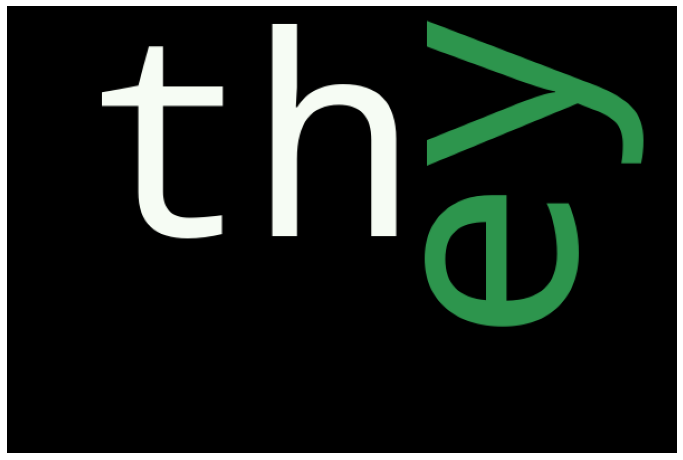

In [18]:
plot_wordcloud(make_wordcloud(ff))

In [ ]:
uv = list(df_neg.usefulCount.values)
uv.sort(reverse=True)

In [ ]:
X = range(0,len(df_neg),50)
Y = []
for x in X:
    Y.append(sum(uv[:x]))
fig, ax = plt.subplots()
ax.plot(X,Y);

## Results function

We'll create a function that takes the pipeline we've created and displays only the results we're interested in.

In [ ]:
def model_results(pipeline):
    # fit the pipeline to the training data
    pipeline.fit(X_train, y_train)
    # generate predictions for the test data
    y_pred = pipeline.predict(X_test)
    # display the training and test accuracy scores
    print(f"Training Score: {round(pipeline.score(X_train, y_train),4)} \
    \nTest Score:     {round(pipeline.score(X_test, y_test),4)}")
    
    # plot the normalized confusion matrix
    plot_confusion_matrix(estimator=pipeline, X=X_test, y_true=y_test, cmap='Greens', 
                          normalize='true', 
                          display_labels=['Non-positive', 'Positive'])

# save and reload preprocessed set

At this stage we will save and reload the preprocessed set in order to avoid taking the time to repeat earlier work everytime we open the notebook.

The saved version has restored or deleted all records with missing condition labels.

We have established pairs in the list `twins` but we have NOT yet deleted either member of any pair or dealt with the confusion between brand and generic drug names.

The size of the dateframe is nearly the same as its original version, roughly 215,000 records.

In the future, store the functions with this?

Store the engineered features list.

In [ ]:
filepath = Path('../data/preprocessed.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(filepath)

In [ ]:
%store engineered_features

In [7]:
df = pd.read_csv('../data/preprocessed.csv')
df.drop(columns='Unnamed: 0', inplace=True)

In [8]:
%store -r engineered_features

# new attempt at modeling

I'll carefully put the pieces together one cell at a time. If it all works, I can combine them later.

* define target feature using thresholds

In [ ]:
useful_threshold = [1, 12]

print(len(df[df.usefulCount <= useful_threshold[0]]), len(df[df.usefulCount >= useful_threshold[1]]))

In [ ]:
df.drop(df[
    (df.usefulCount > useful_threshold[0]) & \
    (df.usefulCount < useful_threshold[1])
].index, inplace=True)

df['target'] = df.usefulCount.apply(lambda x: 1 if x >= useful_threshold[1] else 0)

In [ ]:
X_train, X_test, y_train, y_test = \
train_test_split(df[['review'] + engineered_features], df['target'], test_size=0.2, random_state=SEED)

In [ ]:
# save this value to compare to future model crossval scores
plurality_cv = round(y_train.value_counts(normalize=True)[1],4)
# show the sentiment breakdown
round(y_train.value_counts(normalize=True),4)

----------------------------------

In [ ]:
# reset variables

text_preprocessor = None
numerical_preprocessor = None
preprocessor = None
pipeline = None
accuracy = None
feature_names = None
coefficients = None
decision_function_values = None
importance_df = None
feature_importance = None

In [ ]:
# obtain the standard list of stopwords
nltk.download('stopwords', quiet=True)
# start our own list of stopwords with these words
stop_list = stopwords.words('english')
# add punctuation characters
# for char in string.punctuation:
#     stop_list.append(char)
# add empty string
# stop_list.extend([''])

In [ ]:
# stop words to keep
# 44-59 be/have/do verbs
# 64-178 prepositions/subordinate conjunctions/modals
stop_list = stop_list[:44] + stop_list[60:64]

In [ ]:
# variables of interest

max_features = None
stop_words = stop_list
ngram_range = (2,4)
model = LogisticRegression(max_iter=1000)
# model = SVC(kernel='linear')
# model = MultinomialNB() # does not work
# model = GaussianNB() # does not work
# model = DecisionTreeClassifier(random_state=SEED)
# model = BaggingClassifier()
# model = RandomForestClassifier(random_state=SEED)
# model = AdaBoostClassifier(random_state=SEED)
# model = GradientBoostingClassifier(random_state=SEED)
# model = XGBClassifier(random_state=SEED)
n_features = 25
title = '_____ Model'

In [ ]:
text_preprocessor = TfidfVectorizer(
    max_features=max_features,
    stop_words=stop_words,
    ngram_range=ngram_range
)

In [ ]:
numerical_preprocessor = StandardScaler()

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_preprocessor, 'review'),
        ('numerical', numerical_preprocessor, engineered_features)
    ]
)

In [ ]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

In [ ]:
%%time
pipeline.fit(X_train, y_train);

In [ ]:
accuracy = pipeline.score(X_test, y_test)

In [ ]:
print(f'Accuracy: {accuracy * 100:.2f}%')

In [ ]:
feature_names = preprocessor.named_transformers_['text'].get_feature_names_out().tolist() + engineered_features

In [ ]:
# the success of this code seems to depend on whether we feed it a dense or sparse matrix
# supposedly the .ravel() method will handle either

# this works for SVC, LogisticRegression

# --------------------------------------------------------
if hasattr(model, 'feature_importances_'):
    coefficients = model.feature_importances_
elif hasattr(model.coef_, 'toarray'):
    coefficients = model.coef_.toarray().flatten()
else:
    coefficients = model.coef_.flatten()
# --------------------------------------------------------

# this works for DecisionTreeClassifier, RandomForestClassifier, AdaBoostClassifier
# seems meaningless in the case of AdaBoost

# --------------------------------------------------------
# coefficients = model.feature_importances_
# --------------------------------------------------------

# this works for BaggingClassifier
# (but it might not mean anything?)

# --------------------------------------------------------
# coefficients = np.mean([
#     tree.feature_importances_ for tree in model.estimators_
# ], axis=0)
# --------------------------------------------------------

# coefficients = model.coef_.toarray().flatten()  # Assuming sparse matrix

# coefficients = model.coef_.flatten()  # Assuming dense matrix

# coefficients = model.coef_.ravel()  # should work for dense or sparse matrix

# try:
#     # Try to access coef_ (only available for linear kernels)
#     coefficients = model.coef_.flatten()
# except AttributeError:
#     # Handle the case for non-linear kernels
#     decision_function_values = pipeline.decision_function(X_train)
#     coefficients = (preprocessor.transform(X_train).T @ decision_function_values * y_train).sum(axis=1)

In [ ]:
importance_df = pd.DataFrame(feature_names, columns=['Word'])
importance_df['Importance'] = np.e**(abs(coefficients))
importance_df['Coefficient'] = coefficients

In [ ]:
feature_importance = importance_df.sort_values(
    by = ["Importance"], ascending=False
).head(n_features)

In [ ]:
fig, ax = plt.subplots(figsize=(15,10), ncols=2)
ax[0].set_title(f'Coefficients for {title}')
ax[0].set_ylabel('Word')
ax[0].set_xlabel('Coefficient')
sns.barplot(x='Coefficient', y='Word', data=feature_importance, 
            palette='coolwarm', ax=ax[0])
#plotting feature importances
ax[1].set_title(f'Feature Importances for {title}')
ax[1].set_ylabel('Word')
ax[1].set_xlabel('Importance')
sns.barplot(x='Importance', y='Word', data=feature_importance, 
            palette='coolwarm', ax=ax[1])
plt.tight_layout();

# end